<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/rag/rag_evaluations_uptrain_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

# Evaluate RAG Pipeline using UpTrain and Mistral
Retrieval-augmented generation (RAG) is is a technique for enhancing the accuracy and reliability of LLMs with information retrieved from external sources. 
In this notebook we will be covering 2 main steps: 
1. Implementing RAG
    
    a. Retrieval: Fetch relevant information from a knowledge base, create embeddings and store them in a Vector DB ([FAISS](https://ai.meta.com/tools/faiss/))
    
    b. Generation: Use the retrieved information to the generate information using [Mistral](https://mistral.ai/) LLM
    
2. Evaluting the RAG pipeline (retrieved information and generated response) using [UpTrain](https://uptrain.ai)

If you face any difficulties, need some help with using UpTrain or want to brainstorm custom evaluations for your use-case, you can speak to the maintainers of UpTrain [here](https://calendly.com/uptrain-sourabh/30min).

### Step 1: Install Dependencies

In [1]:
%pip install faiss-cpu mistralai datasets uptrain -q

Note: you may need to restart the kernel to use updated packages.


### Step 2: Import Required Libraries 

In [2]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from datasets import load_dataset
import requests
import numpy as np
import faiss
import os
import json

mistral_api_key= os.environ["MISTRAL_API_KEY"]
client = MistralClient(api_key=mistral_api_key)

### Step 3: Import a Dataset 

In this notebook we will be using the [quac](https://huggingface.co/datasets/quac) dataset available on Hugging Face.

We will be using the user queries and context information from this dataset

In [3]:
# Load Dataset
dataset = load_dataset("quac", split = 'train')   

# Define a list of questions     
question_list = ['Where is the Malayalam language spoken?', 
            'What is the Bohemian Rhapsody?',
            "Who is Michael Bennett?",
            "Where did the 1964 Olympics take place?"] 

# Select context information from the dataset (for simplicity we are using just the first 20 records)
context_list = dataset['context'][:100] 

### Step 4: Split document into chunks (Not required in our case)

For ease of retrieving information, we need to split the context document into smaller chunks.

Though, in this example our context document is already a list of different chunks, hence there's no need to break into further chunks.

In [4]:
# Uncomment if you need to split your context in chunks of a specified size

# chunk_size = 2048
# chunks = [context_list[i:i + chunk_size] for i in range(0, len(context_list), chunk_size)]

In [5]:
chunks = context_list

# Let's Look at the first 2 chunks
chunks[:2] 

['According to the Indian census of 2001, there were 30,803,747 speakers of Malayalam in Kerala, making up 93.2% of the total number of Malayalam speakers in India, and 96.7% of the total population of the state. There were a further 701,673 (2.1% of the total number) in Karnataka, 557,705 (1.7%) in Tamil Nadu and 406,358 (1.2%) in Maharashtra. The number of Malayalam speakers in Lakshadweep is 51,100, which is only 0.15% of the total number, but is as much as about 84% of the population of Lakshadweep. In all, Malayalis made up 3.22% of the total Indian population in 2001. Of the total 33,066,392 Malayalam speakers in India in 2001, 33,015,420 spoke the standard dialects, 19,643 spoke the Yerava dialect and 31,329 spoke non-standard regional variations like Eranadan. As per the 1991 census data, 28.85% of all Malayalam speakers in India spoke a second language and 19.64% of the total knew three or more languages.  Large numbers of Malayalis have settled in Bangalore, Mangalore, Delhi,

### Step 5: Create Embeddings using "mistral-embed" embedding model

Define a function to create embeddings

Here, we have used `mistral-embed` embedding model by Mistral

In [6]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    return embeddings_batch_response.data[0].embedding

Create embeddings for context present in chunks

In [7]:
context_embeddings = np.array([get_text_embedding(chunk) for chunk in chunks])

Create embeddings for list of questions

In [8]:
question_embeddings = np.array([get_text_embedding(question) for question in question_list])

### Step 6: Load into a vector database

After generating the embeddings, we will now be storing them in a Vector DB (FAISS) 

In [9]:
d = context_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(context_embeddings)

### Step 7: Retrieve Context Chunk from Vector DB

Search the Vector DB using `index.search(arg 1, arg 2)`
- `arg 1`: vector of the question embeddings
- `arg 2`: number of similar vectors to retrieve

This function returns the distances and the indices of the most similar vectors to the question vector in the vector database. Then based on the returned indices, we can retrieve the relevant context chunks that correspond to those indices. 

In [10]:
D, I = index.search(question_embeddings, k=2 )  


print(I)

[[ 0  1]
 [95 96]
 [46 71]
 [81 54]]


> **Note** Here, k = number of top chunks fetched i.e k=2 represents we are using best 2 chunks

In [11]:
retrieved_chunk = []

for i in range(len(I)):
    retrieved_chunk.append([chunks[i] for i in I.tolist()[i]])

### Step 8: Generate Response using Mistral

Define a prompt to generate response using Mistral

In [12]:
def create_prompt(retrieved_context, question):
    prompt = f"""
    Context information is below.
    ---------------------
    {retrieved_context}
    ---------------------
    Given the context information and not prior knowledge, answer the query.
    Query: {question}
    Answer:
    """
    return prompt

Define a function to create responses using Mistral Client.

You can refer to this [doc](https://docs.mistral.ai/platform/client/) for information on using Mistral Client.

In [13]:
def run_mistral(user_message, model="mistral-medium"):
    messages = [
        ChatMessage(role="user", content=user_message)
    ]
    chat_response = client.chat(
        model=model,
        messages=messages
    )
    return (chat_response.choices[0].message.content)

### Step 9: Perform Evaluations Using UpTrain's Open-Source Software (OSS)

Define your dataset

UpTrain uses a dictionary list to generate responses. Let's look at the arguments required:

- `question`: The question asked by the user
- `context`: The context used by the LLM to answer the user's query
- `response`: The response generated by the LLM

You can refer to UpTrain [docs](https://docs.uptrain.ai/getting-started/introduction) to learn more about using UpTrain

In [14]:
data = []

for i in range(len(question_list)):
    retrieved_context = retrieved_chunk[i]
    retrieved_context = ' '.join(retrieved_context)
    question = question_list[i]
    response = run_mistral(create_prompt(retrieved_context, question))    
    data.append(
        {
            'question': question,
            'context': retrieved_context,
            'response': response
        }
    )

Let's look at the dataset

In [15]:
data

[{'question': 'Where is the Malayalam language spoken?',
  'context': "According to the Indian census of 2001, there were 30,803,747 speakers of Malayalam in Kerala, making up 93.2% of the total number of Malayalam speakers in India, and 96.7% of the total population of the state. There were a further 701,673 (2.1% of the total number) in Karnataka, 557,705 (1.7%) in Tamil Nadu and 406,358 (1.2%) in Maharashtra. The number of Malayalam speakers in Lakshadweep is 51,100, which is only 0.15% of the total number, but is as much as about 84% of the population of Lakshadweep. In all, Malayalis made up 3.22% of the total Indian population in 2001. Of the total 33,066,392 Malayalam speakers in India in 2001, 33,015,420 spoke the standard dialects, 19,643 spoke the Yerava dialect and 31,329 spoke non-standard regional variations like Eranadan. As per the 1991 census data, 28.85% of all Malayalam speakers in India spoke a second language and 19.64% of the total knew three or more languages.  La

We have used the following 5 metrics from UpTrain's library:

1. [Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance): Evaluates how relevant the retrieved context is to the question specified.

2. [Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness): Evaluates whether the response has answered all the aspects of the question specified.

3. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

4. [Response Relevance](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-relevance): Evaluates how relevant the generated response was to the question specified.

5. [Response Conciseness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-relevance): Evaluates how concise the generated response is or if it has any additional irrelevant information for the question asked.

You can look at the complete list of UpTrain's supported metrics [here](https://docs.uptrain.ai/predefined-evaluations/overview)

In [16]:
from uptrain import Evals, EvalLLM, Settings

import nest_asyncio
nest_asyncio.apply()
from loguru import logger
logger.remove()

settings = Settings(model = 'mistral/mistral-medium', mistral_api_key=os.environ["MISTRAL_API_KEY"])
eval_llm = EvalLLM(settings)

results = eval_llm.evaluate(
    project_name = 'RAG-evaluations-demo',
    data=data,
    checks=[Evals.CONTEXT_RELEVANCE, Evals.RESPONSE_COMPLETENESS, Evals.FACTUAL_ACCURACY, Evals.RESPONSE_RELEVANCE, Evals.RESPONSE_CONCISENESS]
)

100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


> **_NOTE:_**  Don't forget to add `mistral/` before your mistral model name for UpTrain to recognize you are using a Mistral model. <br><br> So, if you are using `mistral-medium` you should add `mistral/mistral-medium` in `Settings`

Let's look at the an evaluation generated by UpTrain

In [17]:
from pprint import pprint
pprint(results[2], indent= 3)

{  'context': 'Bennett was born Michael Bennett DiFiglia in Buffalo, New York, '
              'the son of Helen (nee Ternoff), a secretary, and Salvatore '
              'Joseph DiFiglia, a factory worker. His father was Roman '
              'Catholic and Italian American and his mother was Jewish. He '
              'studied dance and choreography in his teens and staged a number '
              'of shows in his local high school before dropping out to accept '
              'the role of Baby John in the US and European tours of West Side '
              "Story.  Bennett's career as a Broadway dancer began in the 1961 "
              'Betty Comden-Adolph Green-Jule Styne musical Subways Are for '
              "Sleeping, after which he appeared in Meredith Willson's Here's "
              'Love and the short-lived Bajour. In the mid-1960s he was a '
              'featured dancer on the NBC pop music series Hullabaloo, where '
              'he met fellow dancer Donna McKechnie.  Be

### Visualize Results using UpTrain's Dashboards

You can also visualize these results using UpTrain's dashboards.

These dashboards are a part of our Open Source Offering. You can check it out on our [Github](https://github.com/uptrain-ai/uptrain).

You can run these dashboards **locally on your system**, check out our [documentation](https://docs.uptrain.ai/dashboard/getting_started) to get started.

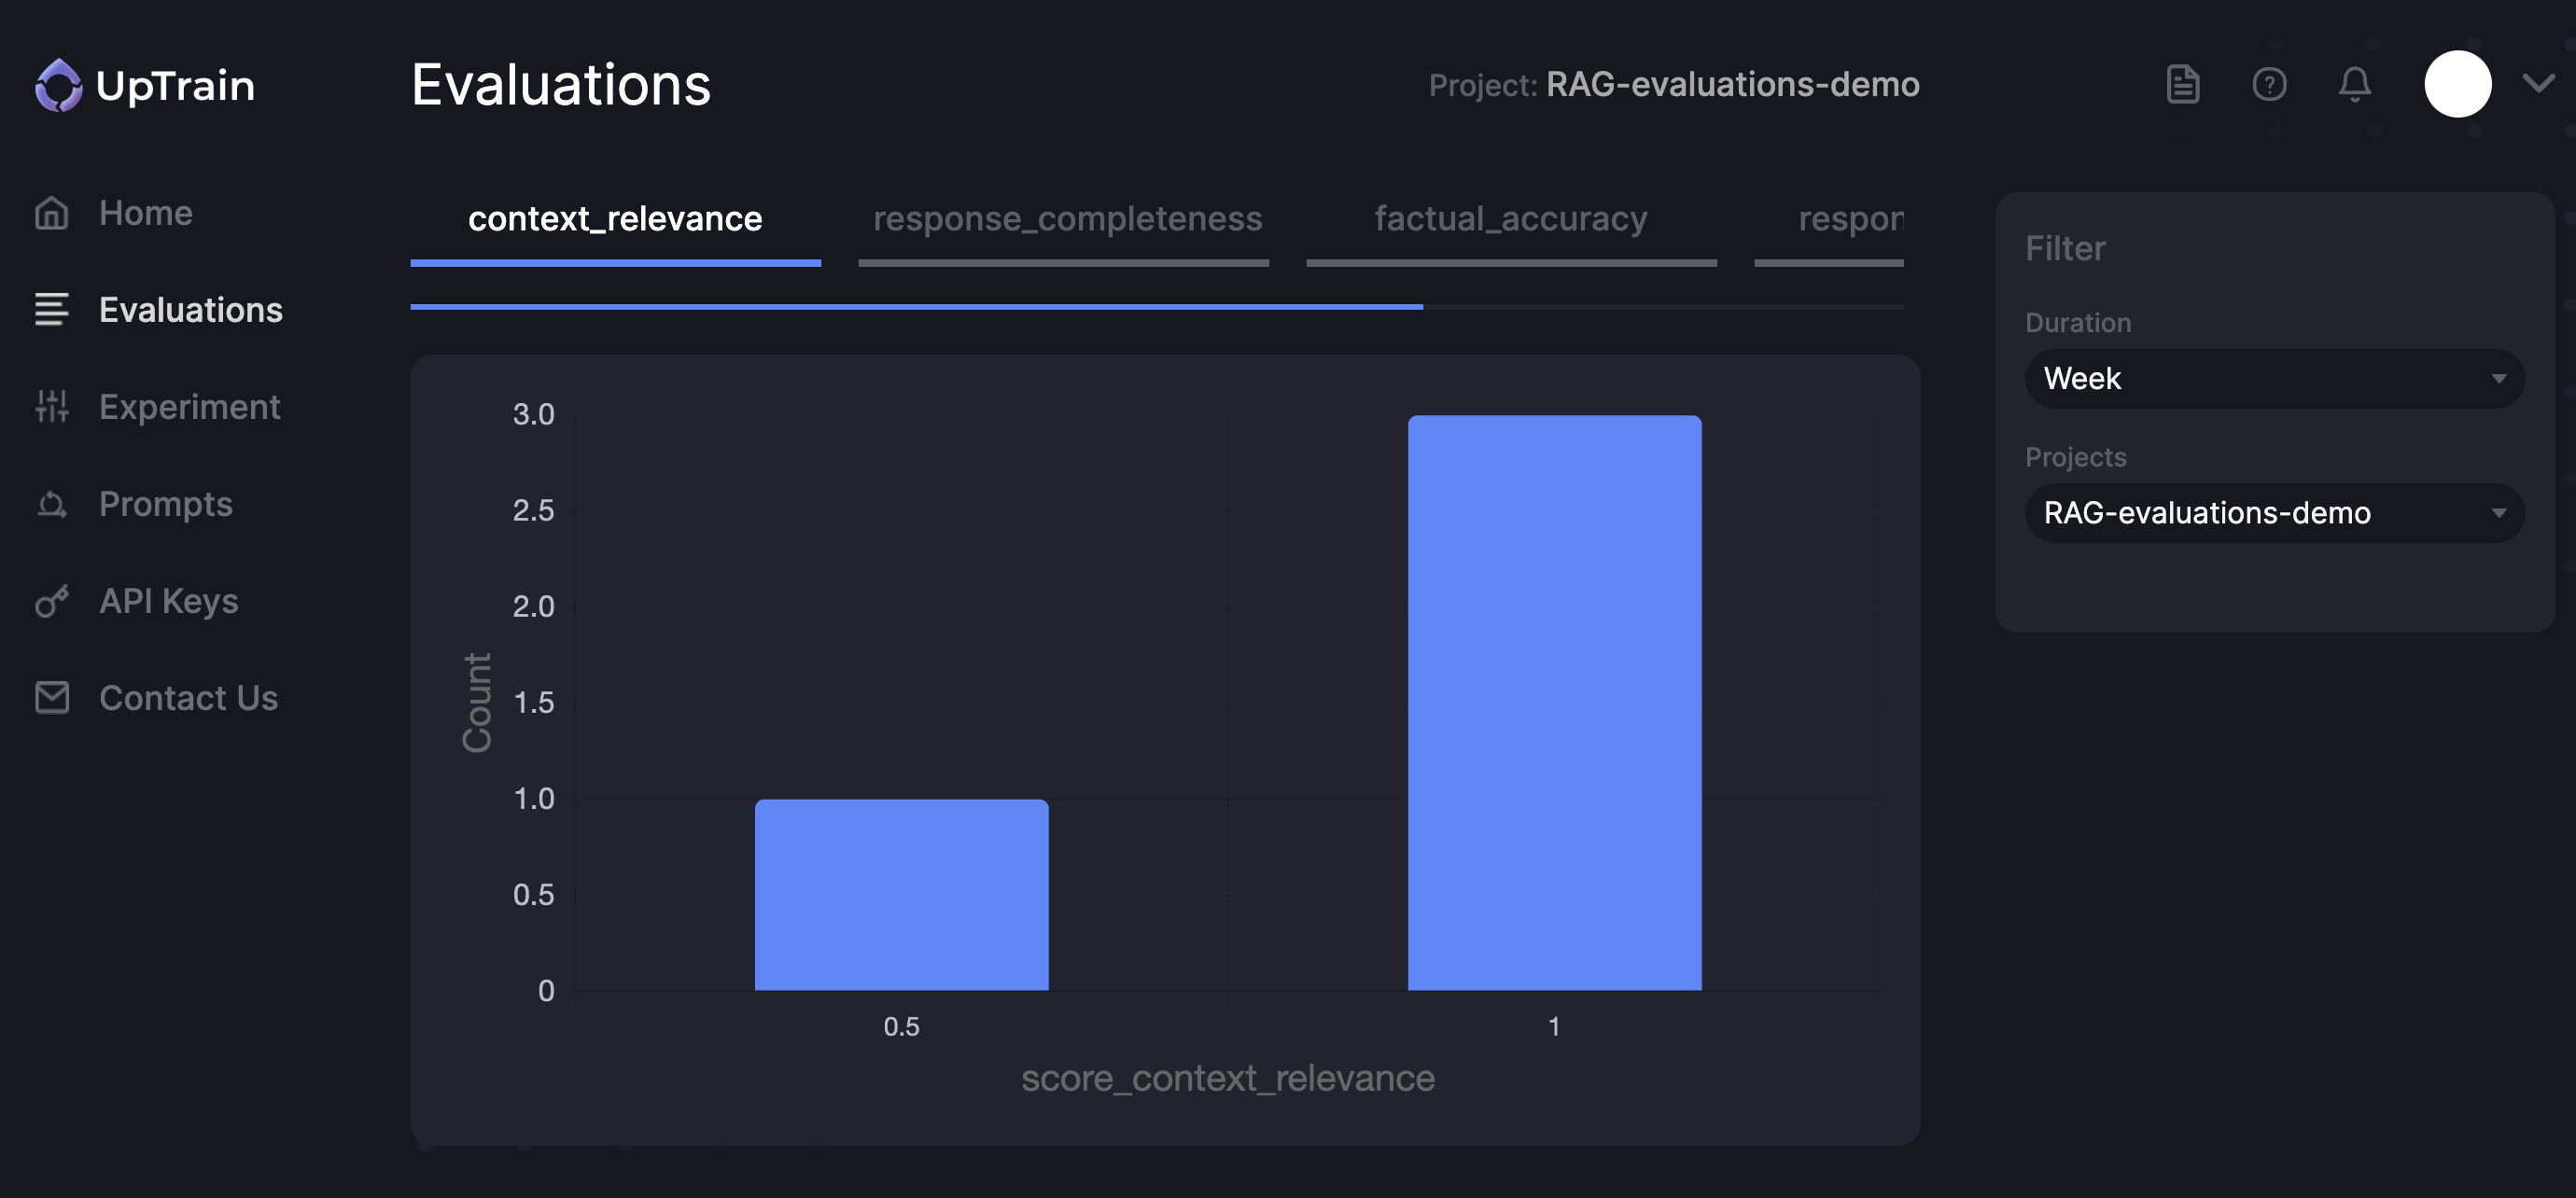

Using UpTrain dashboards you can also see logs of individual data points and get key insights

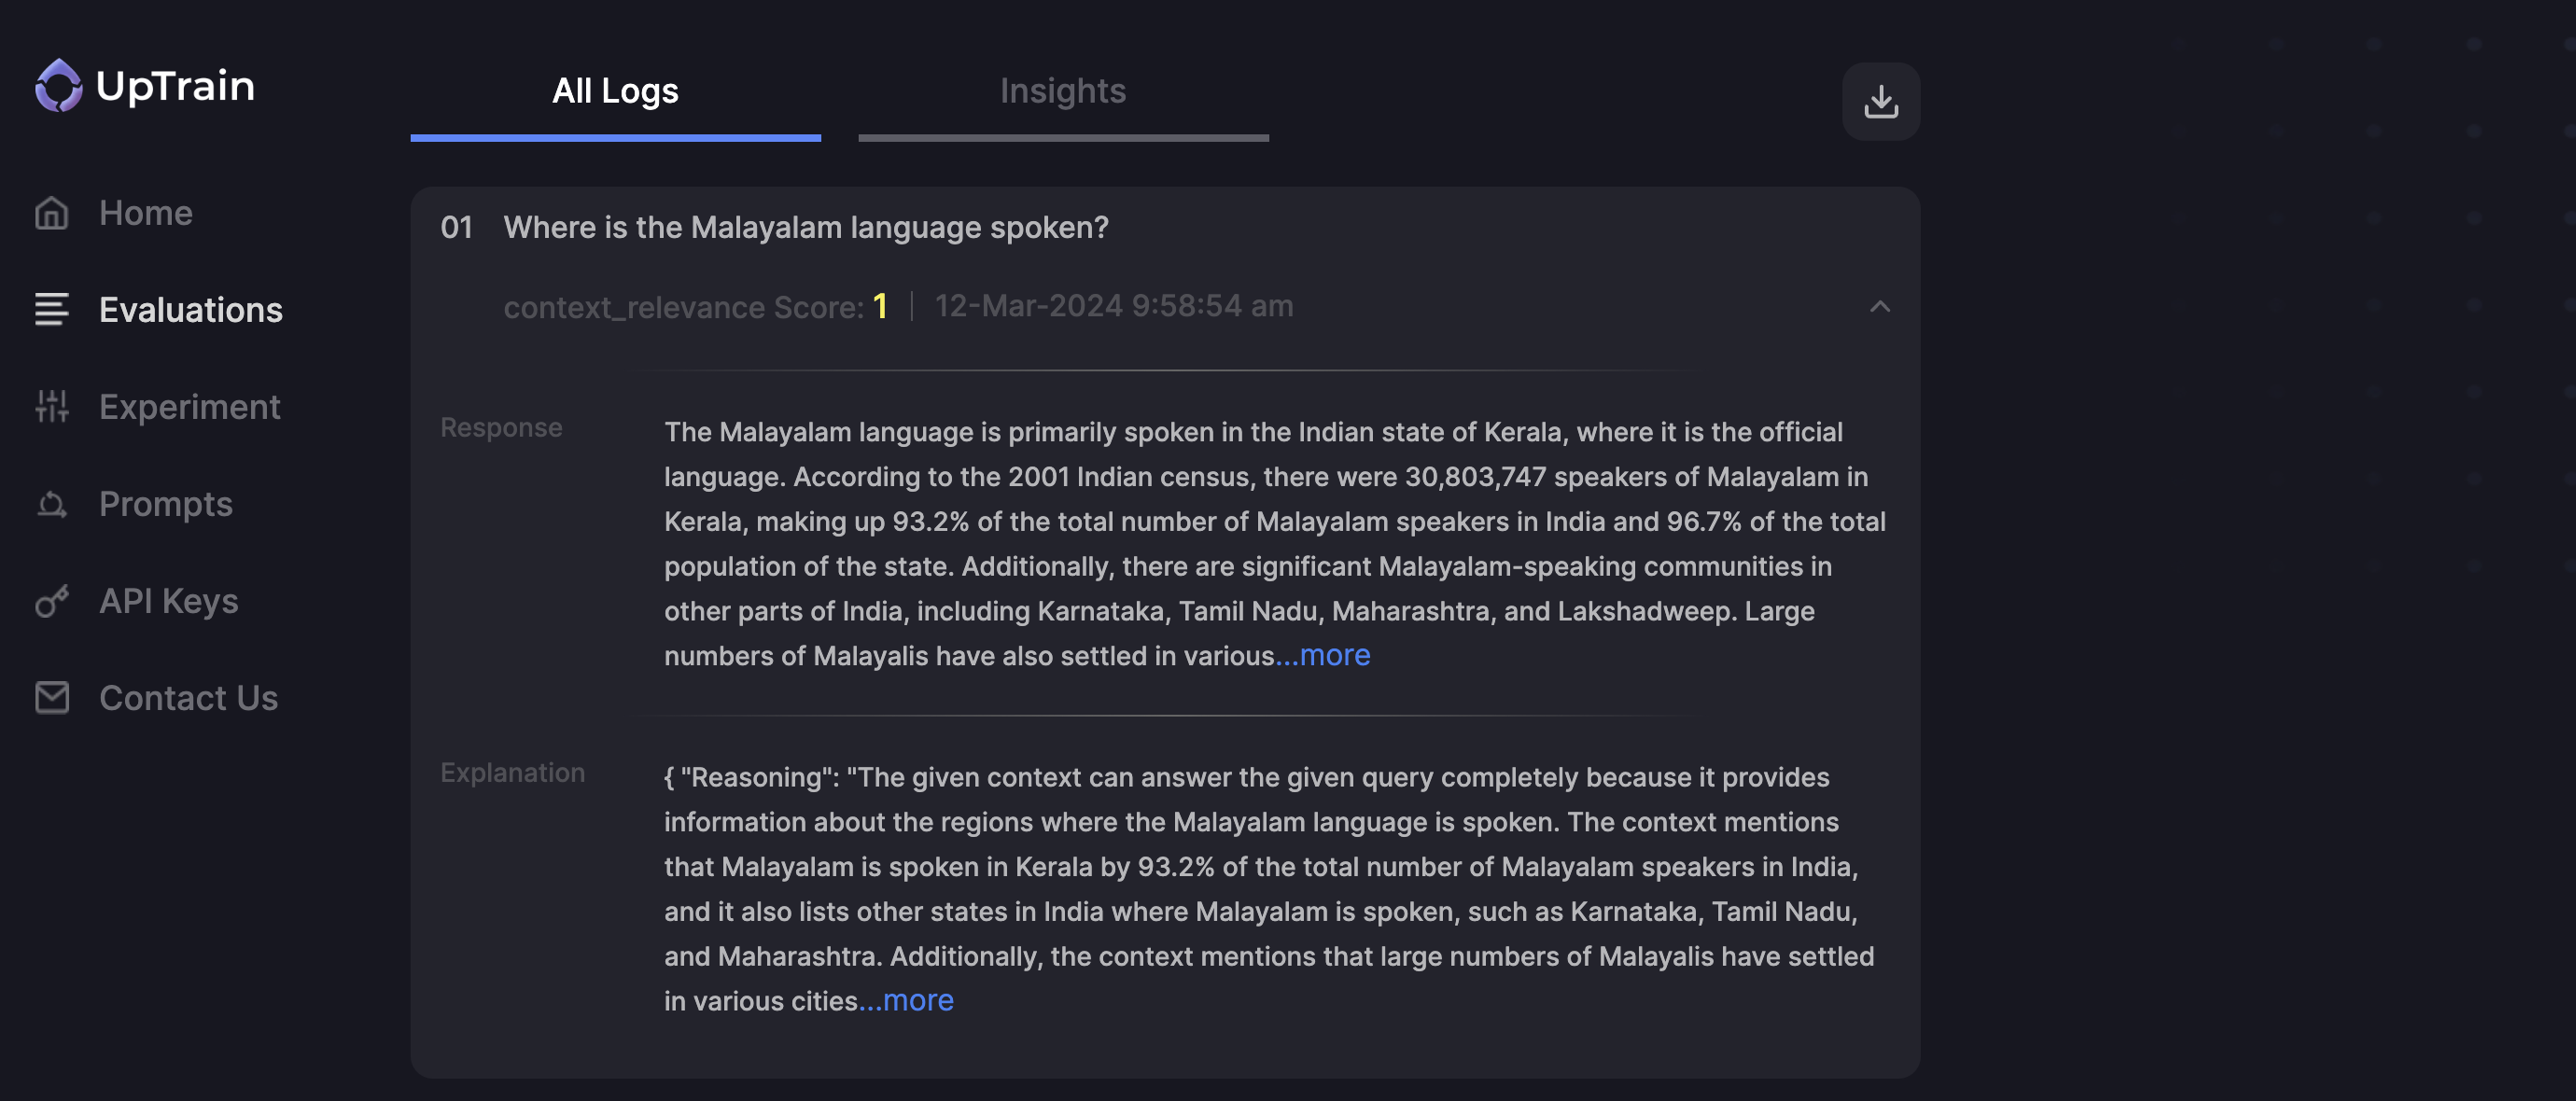